In [3]:
import numpy as np
import pymultinest as pmn
import matplotlib as plt

import os
import corner
import glob
import sys

from astropy.cosmology import wCDM, FlatwCDM
from astropy.cosmology import w0waCDM, Flatw0waCDM


ModuleNotFoundError: No module named 'all_distances'

In [2]:
os.getcwd()

'/Users/markpoe/ZTF/lowzSN/notebooks'

In [4]:
import sys
print (sys.path)

['', '/Users/markpoe/astroml_miniconda3/lib/python36.zip', '/Users/markpoe/astroml_miniconda3/lib/python3.6', '/Users/markpoe/astroml_miniconda3/lib/python3.6/lib-dynload', '/Users/markpoe/.local/lib/python3.6/site-packages', '/Users/markpoe/.local/lib/python3.6/site-packages/pymultinest-2.6-py3.6.egg', '/Users/markpoe/astroml_miniconda3/lib/python3.6/site-packages', '/Users/markpoe/astroml_miniconda3/lib/python3.6/site-packages/exoticDE_fit-0.0.1-py3.6.egg', '/Users/markpoe/astroml_miniconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/markpoe/.ipython']


In [3]:
!which python

/Users/markpoe/astroml_miniconda3/bin/python


In [24]:
### Temporarily not in use
# wwcdm = wCDM(H0=70., Om0=0.3, Ode0=.7, w0= -1.)
# je = wwcdm.distmod(z=np.arange(0.01,.1,.003))
# print (je)
# print (len(je))

In [8]:
# wwcdm = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)

In [9]:
wwcdm = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)

In [10]:
### Generate mu's by hand
data_path = '../jla_data/'
jla_bins = np.loadtxt(data_path + '/dist_binned.txt') ### original
cov_mat = np.loadtxt(data_path + 'covmat_binned.txt')

je = wwcdm.distmod((jla_bins[:,0]))
je = dist_thaw(jla_bins[:,0],.3,-.9,1.,70.)
print (len(je))

l = np.sort(je)
print (l)

np.savetxt('by_hand.txt', l)
j = np.loadtxt('by_hand.txt', usecols = 0)

31
[33.1741933  33.57318958 33.91100502 34.20403771 34.58179929 35.00276554
 35.27354236 35.66302451 36.05620501 36.39144544 36.77371671 37.13970285
 37.48878507 37.84932859 38.23494338 38.6087138  38.98624    39.37493076
 39.76410141 40.14719681 40.5493109  40.94868162 41.35417632 41.76927921
 42.18348594 42.60823366 43.03196178 43.4638829  43.89809239 44.3320292
 44.76892843] mag


In [11]:
#define all the data here (currently SN only)

vs = np.vstack([sorted(jla_bins[:, 0]), sorted(jla_bins[:, 1])]).T # Transpose using jla original
vv = np.vstack([sorted(jla_bins[:, 0]), (j)]).T # Transpose using the by-hand array

np.savetxt('../jla_data/dist_binned_A.txt', vs) # Save the .T matrix
jla_bins_a = np.loadtxt(data_path + '/dist_binned_A.txt') # Load the .T matrix
np.savetxt('../jla_data/dist_binned_B.txt', vv) # Save the .T matrix using the by-hand array
jla_bins_b = np.loadtxt('../jla_data/dist_binned_B.txt')# Load the .T-by-hand matrix

cov_mat *= 1e-6
Cinv = np.linalg.inv(cov_mat)

In [234]:
def llhood(model_param, ndim, npar):
    """
    This is the function where we define the log likelihood 
    log(Lhood) = -0.5*chisquare
    
    Parameters
    ----------
    model_param : sequence
        sequence of model parameters (Om, w, H0, M)
        in a wCDM    
    ndim : integer
         length of model_params
    npar : integer
        The number of parameters 
    """
    
    # Calculate mu using priors and z from jla
    om, W0, Wa, h0, M = [model_param[i] for i in range(5)]
    
    # Define a model using priors
    wc = w0waCDM(H0=h0, Om0=om, Ode0=1-om, w0=W0, wa=Wa)
#     wc = Flatw0waCDM(H0, om, w0=w0, wa=wa)

    dl_mpc = wc.luminosity_distance(jla_bins[:,0]).value # Using jla data
    mu_th = 5*np.log10(dl_mpc) + 25.
    
    # Calulate chi2 using (mu_th) - (mu_some_input_such_as_jla or by hand) 
#     dif_arr = mu_th - jla_bins_a[:,1] + M # Using jla mu .T
    dif_arr = mu_th - jla_bins_b[:,1] + M # Using by-hand data
    
    chisq = np.dot(dif_arr.T, np.dot(Cinv, dif_arr)) + ((om - 0.3)**2.)/((.9)**2.)
    return -0.5*chisq
    
def prior(cube, ndim, npar): # for models with more pars
    """
    Define the prior for each parameter
    cube[0] = om
    cube[1] = w0
    cube[2] = wa
    cube[3] = H0
    cube[4] = M
    
    """
    cube[0]  = cube[0]*1
    cube[1]  = cube[1]*4 - 2
    cube[2]  = cube[2]*6 - 3
    cube[3]  = cube[3]*50 + 50
    cube[4]  = cube[4]*0.00000000000001

    
# Similarly defined functions for running model comparisons at the same time
def llhood2(model_param, ndim, npar):
    om, w, h0, M = [model_param[i] for i in range(4)]
    
    wc = wCDM(H0=h0, Om0=om, Ode0=1-om, w0=w)
#     wc = FlatwCDM(H0=H0, Om0=om, w0=w)

    dl_mpc = wc.luminosity_distance(jla_bins[:,0]).value # Using jla data
    mu_th = 5*np.log10(dl_mpc) + 25.
    
#     dif_arr = mu_th - jla_bins_a[:,1] + M # Using jla mu .T
    dif_arr = mu_th - jla_bins_b[:,1] + M # Using by-hand data
    
    chisq = np.dot(dif_arr.T, np.dot(Cinv, dif_arr)) + ((om - 0.3)**2.)/((1e-15)**2.)
    return -0.5*chisq
    
def prior2(cube, ndim, npar): # for models with less pars
    cube[0]  = cube[0]*1
    cube[1]  = cube[1]*4 - 2
    cube[2]  = cube[2]*50 + 50
    cube[3]  = cube[3]*0.00000000000001

In [239]:
prefix = 'jla_w0waCDM_sig_0009'
chain_dir = ('/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix + '/')

if not os.path.exists(chain_dir):
    os.makedirs(chain_dir)

### For running model comparisons at the same time
prefix2 = 'jla_w0waCDM_sig_06'
chain_dir2 = ('/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix2 + '/')

if not os.path.exists(chain_dir2):
    os.makedirs(chain_dir2)

In [233]:
pmn.run(llhood, prior, 5, verbose=True, n_live_points=700, outputfiles_basename=chain_dir)

# ### for running model comparisons at the same time and for a model with less parameters
# pmn.run(llhood2, prior2, 4, verbose=True, outputfiles_basename=chain_dir2) ### for less pars

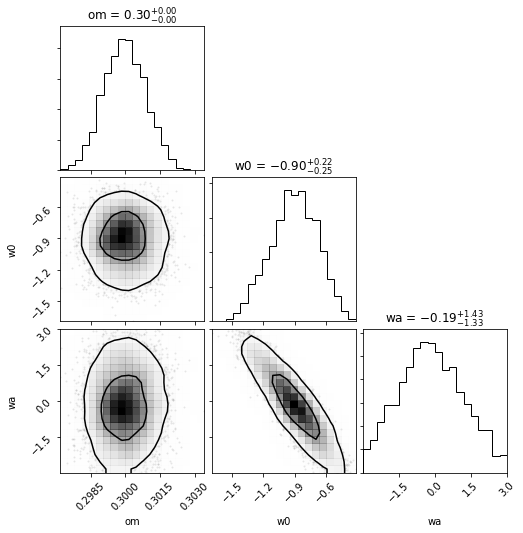

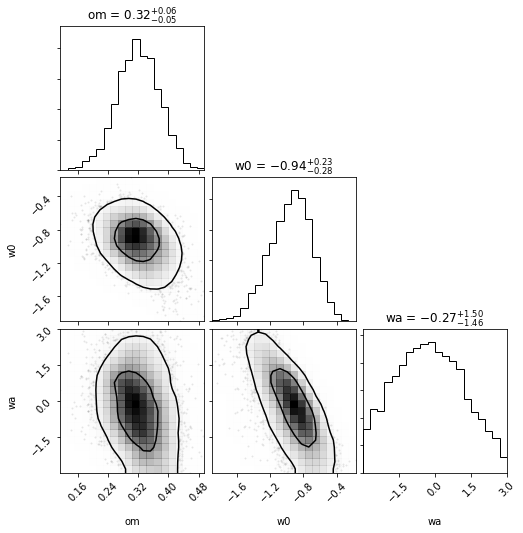

In [240]:
data = np.loadtxt(chain_dir+'post_equal_weights.dat')
figure = corner.corner(data[:,[0,1,2]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], show_titles=True)#, truths=[.3,-.9,-.1,70.,None,None])
# figure = corner.corner(data, smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], show_titles=True, truths=[.3,-.9,-.1,70.,None,None])

data2 = np.loadtxt(chain_dir2+'post_equal_weights.dat')
# figure2 = corner.corner(data2[:,[0,1]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w','h0', 'M', 'llhood'],show_titles=True, truths=[.3,-.9,70.,None,None])
figure = corner.corner(data2[:,[0,1,2]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], show_titles=True)#, truths=[.3,-.9,-.1,70.,None,None])

In [243]:

### Find log evidence and calculate delta log evidence for two models

# Define variables for use in a loop
chains_directory = '/Users/markpoe/ZTF/lowzSN/notebooks/chains/'
stat = '/stats.dat'
model_one =  prefix # i.e. 'test6_modchi2'
model_two =  prefix2 # i.e. 'jla_wCDM_vs_by_hand2'
Model_1 = chains_directory + model_one +  stat
Model_2 = chains_directory + model_two +  stat


# Build array of log evs for two models
ev = []
models = [Model_1,Model_2]
for x in models:
    with open(x, "r") as f:
        for line in f:
            if "Nested Sampling Global Log-Evidence" in line:
                ev.append(line)
    f.close()
print (ev)


# Extract the evidences from the above array and convert to float
z = []
for x in ev:
    y = x.split(':')
    t = y[1].split('+/-')
    z.append(t[0])
ev1,ev2 = float(z[0]), float(z[1])
print ('\n','Log evs as floats','\n',ev1,ev2)


# Calculate and print delta of the log evidences
delta_lnE = np.abs(ev1 - ev2)
print ('\n','Delta Log Evidence of the two models','\n',delta_lnE)


['Nested Sampling Global Log-Evidence           :   -0.126112817851822268E+02  +/-    0.123817328349264386E+00\n', 'Nested Sampling Global Log-Evidence           :   -0.837935910460231348E+01  +/-    0.969099797406359348E-01\n']

 Log evs as floats 
 -12.611281785182227 -8.379359104602313

 Delta Log Evidence of the two models 
 4.231922680579913


In [244]:

# Print evidences and the abs value of delta evidences
e1 = np.exp(ev1)
e2 = np.exp(ev2)
print (e1)
print (e2)
delta_evidence = np.abs(e1 - e2)
print ('\n','Delta evidence','\n', delta_evidence)


# Print Bayes factor ev1/ev2
Bayes_factor = np.divide(np.exp(ev1),np.exp(ev2))
# Bayes_factor = np.divide(np.exp(ev2),np.exp(ev1))

# Print log of the Bayes Factor, should be same as delta log evs
log_bayes_factor = np.abs(np.log(Bayes_factor))
print ('\n','Log Bayes Factor (Delta Log evs)','\n',log_bayes_factor)


# If the log bayes is negative, can use this to find bayes factor
# Bayes factor for real this time
Bayes_factor = np.exp(np.abs(log_bayes_factor))
print ('\n','Bayes Factor','\n',Bayes_factor)


3.3341866707294397e-06
0.00022955702035849787

 Delta evidence 
 0.00022622283368776844

 Log Bayes Factor (Delta Log evs) 
 4.231922680579913

 Bayes Factor 
 68.84948055661091


In [18]:
a = pmn.analyse.Analyzer(5, outputfiles_basename = chain_dir)

  analysing data from /Users/markpoe/ZTF/lowzSN/notebooks/chains/test1_jla_w0waCDM/.txt


In [21]:
a.get_data()